In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import pandas as pd
import torchtext
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import vocab
import math
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import optuna

In [2]:
softmax = nn.Softmax(dim=-1)
def run_epoch(model, loss_func, data_loader, device, epoch, optimizer=None, score_funcs=None):
    running_loss = 0.0 #loss of the epoch
    scores = dict() #will store the results of score functions
    if score_funcs is not None:
        score = {str(i): [] for i in score_funcs.keys()}
    for inputs, labels in tqdm(data_loader, desc=f"epoch: {epoch[0]+1}/{epoch[1]}", position=0):
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_hat = model(inputs)
        loss = loss_func(y_hat, labels)
        if model.training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if score_funcs is not None:
            y_hat_soft = softmax(y_hat.cpu())
            y_pred = [np.argmax(y_hat_soft[i,:]) for i in range(len(labels))]
            for i in score_funcs.keys():
                score[str(i)].append(score_funcs[i](labels.tolist(), y_pred))
        running_loss += loss.item()
    if score_funcs is not None:
        scores = {i: sum(score[i])/len(score[i]) for i in score_funcs.keys()}
    return running_loss, scores

In [3]:
def train_network(model, loss_func, training_loader, optimizer, lr_schedule, 
    score_funcs=None, testing_loader=None, val_loader=None, epochs=20, device="cpu",\
    checkpoint_file=None):
    model.to(device)
    losses = []
    scores = None #store the dict of scores
    for epoch in range(epochs):
        model = model.train()
        losses.append(run_epoch(model, loss_func, training_loader, device, \
            [epoch, epochs], optimizer=optimizer)[0])
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau) \
                and val_loader is not None:
                model.eval()
                with torch.no_grad():
                    eval_loss = run_epoch(model, loss_func, val_loader, device, \
                        [epoch, epochs])[0]
                lr_schedule.step(eval_loss)
            else:
                lr_schedule.step()
    if score_funcs is not None and testing_loader is not None:
        model = model.eval()
        with torch.no_grad():
            scores = run_epoch(model, loss_func, testing_loader, device, [epoch, epochs], \
                score_funcs=score_funcs)[1]
    if checkpoint_file is not None:
        torch.save({'model': model, 'model_state_dict':model.state_dict(), \
            'optimizer_state_dict': optimizer.state_dict()}, checkpoint_file)
    return losses, scores

In [4]:
def moveTo(obj, device): #move items of different datastructures to device
    if isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    elif hasattr(obj, 'to'):
        return obj.to(device)
    else:
        return obj

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
        (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
        self.batch_first = batch_first
    def forward(self, x):
        if self.batch_first:
            x = x.permute(1, 0, 2)
        x = x *np.sqrt(self.d_model) + self.pe[:x.size(0), :]
        x = self.dropout(x)
        if self.batch_first:
            x = x.permute(1, 0, 2)
        return x

In [6]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.heads = heads
        self.head_dim = embed_dim // heads #dim of each matrix
        assert (
            self.head_dim * heads == embed_dim), \
           "Embedding size needs to be divisible by heads"
        self.values = nn.Linear(embed_dim, embed_dim)
        self.keys = nn.Linear(embed_dim, embed_dim)
        self.queries = nn.Linear(embed_dim, embed_dim)
        self.fc_out = nn.Linear(embed_dim, embed_dim)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], \
            query.shape[1]
        values = self.values(values)  # (N, value_len, embed_dim)
        keys = self.keys(keys)  # (N, key_len, embed_dim)
        queries = self.queries(query)  # (N, query_len, embed_dim)
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)
        score = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        # score: (N, heads, query_len, key_len)
        if mask is not None:
            score = score.masked_fill(mask == 0, float("-1e20"))
        attention_weights = torch.softmax(score / (self.embed_dim ** (1 / 2)), dim=3)
        # attention_weights shape: (N, heads, query_len, key_len)
        out = torch.einsum("nhql,nlhd->nqhd", [attention_weights, values]).reshape( \
            N, query_len, self.heads * self.head_dim)
        # (N, query_len, embed_dim)
        out = self.fc_out(out)
        return out

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, heads, dropout, forward_expansion):
        super().__init__()
        self.attention = SelfAttention(embed_dim, heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.feed_forward = nn.Sequential( \
            nn.Linear(embed_dim, forward_expansion * embed_dim), \
            nn.LeakyReLU(0.1), \
            nn.Linear(forward_expansion * embed_dim, embed_dim))
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

In [8]:
class Encoder(nn.Module):
    def __init__(self, VOCAB_SIZE, embed_dim, num_layers, heads, \
        device, forward_expansion, dropout, padding_idx=None):
        super().__init__()
        self.embed_dim = embed_dim
        self.device = device
        self.word_embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx)
        self.position_embedding = PositionalEncoding(embed_dim, batch_first=True)
        self.layers = nn.ModuleList(
            [TransformerBlock(embed_dim,heads,dropout=dropout,
            forward_expansion=forward_expansion) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        N, seq_length = x.shape
        x = self.word_embedding(x)
        x = self.position_embedding(x)
        out = self.dropout(x)
        for layer in self.layers:
            out = layer(out, out, out, None)
        return out

In [9]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, heads, forward_expansion, dropout, device):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.attention = SelfAttention(embed_dim, heads=heads)
        self.transformer_block = TransformerBlock(
            embed_dim, heads, dropout, forward_expansion)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key, mask):
        attention = self.attention(x, x, x, mask)
        query = self.dropout(self.norm(attention + x))
        out = self.transformer_block(value, key, query, None)
        return out

In [10]:
class Decoder(nn.Module):
    def __init__(self, VOCAB_SIZE, embed_dim, num_layers, NUM_CLASS,
        heads, forward_expansion, dropout, device,padding_idx=None):
        super().__init__()
        self.device = device
        self.word_embedding = nn.Embedding(VOCAB_SIZE, embed_dim, padding_idx=padding_idx)
        self.position_embedding = PositionalEncoding(embed_dim, batch_first=True)
        self.layers = nn.ModuleList(
            [DecoderBlock(embed_dim, heads, forward_expansion, dropout, device)
                for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, mask):
        N, seq_length = x.shape
        x = self.word_embedding(x)
        x = self.position_embedding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, enc_out, enc_out, mask)
        return x

In [11]:
class Transformer(nn.Module):
    def __init__(self,VOCAB_SIZE,NUM_CLASS, embed_dim=512,
        num_layers=4,forward_expansion=4,heads=6,dropout=0,
        device="cpu",padding_idx=None):
        super().__init__()
        self.encoder = Encoder(VOCAB_SIZE,embed_dim,num_layers,
            heads,device,forward_expansion,dropout, padding_idx)
        self.decoder = Decoder(VOCAB_SIZE,embed_dim,num_layers,
            NUM_CLASS,heads,forward_expansion,dropout, device,padding_idx)
        self.device = device
        self.attn = AttentionAvg(AdditiveAttentionScore(embed_dim))
        self.pred = nn.Sequential(nn.Flatten(),nn.Linear(embed_dim, embed_dim), \
            nn.LeakyReLU(0.1),nn.BatchNorm1d(embed_dim),nn.Linear(embed_dim, NUM_CLASS))
        self.padding_idx = padding_idx

    def make_mask(self, x):
        N, x_len = x.shape
        mask = torch.tril(torch.ones((x_len, x_len))).expand(
            N, 1, x_len, x_len)
        return mask.to(self.device)

    def forward(self, x):
        mask = self.make_mask(x)
        enc_src = self.encoder(x)
        out = self.decoder(x, enc_src, mask)
        if self.padding_idx is not None:
            pad_mask = x != self.padding_idx
        else:
            pad_mask = x == x
        context = out.sum(dim=1)/pad_mask.sum(dim=1).unsqueeze(1)
        return self.pred(self.attn(out, context, mask=pad_mask))

In [12]:
class AttentionAvg(nn.Module):
    def __init__(self, attnScore):
        super(AttentionAvg, self).__init__()
        self.score = attnScore
    def forward(self, states, context, mask=None):
        B = states.size(0)
        T = states.size(1)
        D = states.size(2)
        scores = self.score(states, context)
        if mask is not None:
            scores[~mask] = float(-10000)
        weights = F.softmax(scores, dim=1)
        context = (states*weights).sum(dim=1)
        return context.view(B, D)

In [13]:
class AdditiveAttentionScore(nn.Module):
    def __init__(self, H):
        super().__init__()
        self.v = nn.Linear(H, 1)
        self.w = nn.Linear(2*H, H) #2H due to concatenation
    def forward(self, states, context):
        T = states.size(1)
        context = torch.stack([context for _ in range(T)], dim=1)
        state_context_combined = torch.cat((states, context), dim=2)
        scores = self.v(torch.tanh(self.w(state_context_combined)))
        return scores

In [14]:
class SentimentDataset(Dataset):
    def __init__(self, lang_pairs, Vocab, tokenizer):
        self.lang_pairs = lang_pairs
        self.Vocab = Vocab
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.lang_pairs)
    def __getitem__(self, idx):
        data = self.lang_pairs.loc[idx]
        x = [self.Vocab['<SOS>']] + [self.Vocab[token] if token in self.Vocab else self.Vocab['<unk>']
            for token in self.tokenizer(data["tweet"])] + [self.Vocab['<EOS>']]
        y = data["sentiment"]
        x = torch.tensor(x, dtype=torch.int64)
        y = torch.tensor(y, dtype=torch.int64)
        return x, y


# Preprocessing
- Loading the dataset
- Looking at length distribution
- Creating a vocabulary

In [15]:
column_names = ["sentiment", "id", "date", "query", "username", "tweet"]
df = pd.io.parsers.read_csv("training.1600000.processed.noemoticon.csv", encoding="ISO-8859-1", names=column_names)

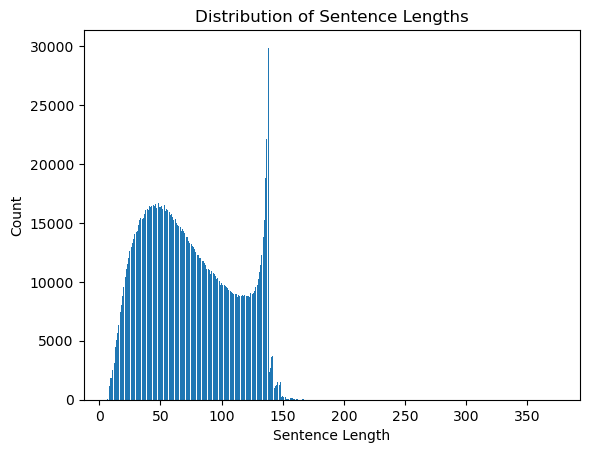

In [16]:
x = df["tweet"].str.len().value_counts()
plt.bar(x.index, x.values)
plt.title("Distribution of Sentence Lengths")
plt.xlabel("Sentence Length")
plt.ylabel("Count")
plt.show()


In [17]:
df.dropna(inplace=True)

In [18]:
df['sentiment'] = df['sentiment'].replace(4, 1) 
df = df[df['tweet'].str.len() < 100]
df.reset_index(inplace=True)

In [19]:
tokenizer = get_tokenizer('basic_english')
counter = Counter()
for i in range(len(df)):
    counter.update(tokenizer(df.loc[i]["tweet"]))
Vocab = vocab(counter, min_freq=10, specials=('<unk>', '<SOS>', '<EOS>', '<PAD>'))

In [20]:
dataset = SentimentDataset(df, Vocab, tokenizer)
train_size = round(len(dataset)*0.9)
test_size = len(dataset)-train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, \
    [train_size, test_size])

In [21]:
VOCAB_SIZE = len(Vocab)
NUM_CLASS = len(df["sentiment"].unique())
padding_idx = Vocab['<PAD>']
embed_dim = 126
B = 92
epochs = 6
device = "cuda"

In [22]:
def pad_batch(batch):
    labels = [z[1] for z in batch]
    texts = [z[0] for z in batch]
    max_len = max([text.size(0) for text in texts])
    texts = [F.pad(text, (0,max_len-text.size(0)),value=padding_idx) for text in texts]
    x, y = torch.stack(texts), torch.tensor(labels, dtype=torch.int64)
    return x, y

In [23]:
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True, \
    collate_fn=pad_batch)
test_loader = DataLoader(test_dataset, batch_size=B, collate_fn=pad_batch)

# Training

In [24]:
transformer = Transformer(VOCAB_SIZE, NUM_CLASS,embed_dim, 
    device=device, padding_idx=padding_idx, dropout=.2)

device = "cuda"
transformer = Transformer(VOCAB_SIZE, NUM_CLASS,embed_dim, 
    device=device, padding_idx=padding_idx, dropout=.2)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(transformer.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs//3,eta_min=0.0003)

transformer_results = train_network(transformer, loss_func, \
    train_loader, optimizer, scheduler, epochs=epochs, device=device,
    checkpoint_file="transformerModel_new.pt")

# Evaluation

In [25]:
checkpoint_dict = torch.load('transformerModel_new.pt', map_location="cuda")
transformer.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

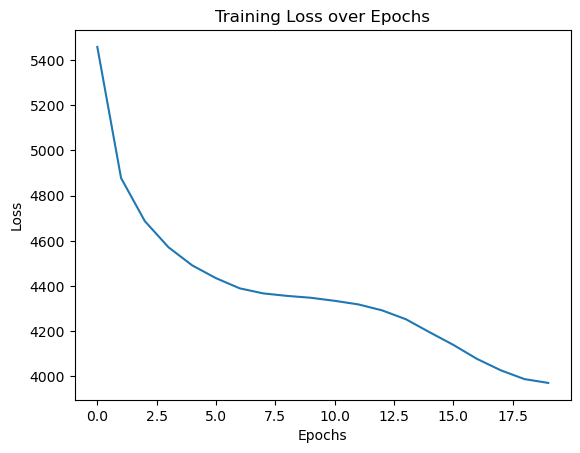

In [28]:
plt.plot(range(20), transformer_results[0] )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.show()

In [29]:
transformer = transformer.eval().to(device)
y_pred = []
y_test = []
with torch.no_grad():
    for x, y in test_loader:
        outputs = transformer(x.to(device))
        _, predicted = torch.max(outputs, 1)
        y_pred += predicted.tolist()
        y_test += y.tolist()

In [30]:
cm = confusion_matrix(y_test, y_pred)
rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)
print("Recall: {}\nPrecision: {}\nF1-Score: {}\nAccuracy: {}\n".format(rf_Recall, rf_Precision, rf_f1, rf_accuracy))
print(cm)

Recall: 0.8573631721443504
Precision: 0.8480770208654678
F1-Score: 0.8526948148779344
Accuracy: 0.8508455565142364

[[48579  8963]
 [ 8324 50034]]
